# Notebook 2:

In [29]:
from IPython.display import Image, display
from pipeline.dnn import FCNN, CNN
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import numpy as np
from pipeline.helpers import correlation
import optuna
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0);

# Deep neural networks

Unlike the linear models of the last notebook, deep neural networks are heavily parameterised, nonlinear models. The neural networks here consist of stacked layers of interconnected nodes. The FCNN has around 12 million parameters, whereas the CNN has around 9000 parameters. For comparison, the linear models have around 3000 parameters.

Unlike the linear models, the DNNs have no closed-form solution for the optimal coefficients. Therefore, we resort to gradient-descent-based algorithms to tune their parameters.

The DNNs rely on a number of hyperparameters (whereas the linear models only relied on the regularisation parameter). In this tutorial, to save time, we have provided a set of hyperparameters already tuned to the envelope decoding task. We will show you how to tune one of the hyperparameters called the learning rate.

<img src="../images/architectures.png" width="800"/>

# Fitting the FCNN for a single participant

We will use the same training/validation/testing data split as we did for the linear models. We'll also look at fitting the FCNN to data from the first participant:

In [5]:
participant = 0
data_dir = '/media/mdt20/Storage/data/mldecoders/data/hugo/0.5-8Hz/data.h5'

train_parts = range(9)
val_parts = range(9,12)
test_parts = range(12, 15)

Now let's define the pre-determined hyperparameters. We will overwrite the learning (`lr`) parameter later.

In [6]:
fcnn_hyperparameters = {"num_hidden": 3, "dropout_rate": 0.45}
fcnn_train_params = {"lr": 0.0001, "batch_size": 256, "weight_decay": 0.0001}

cnn_hyperparameters = {"dropout_rate": 0.20,"F1": 8,"D": 8,"F2": 64}
cnn_train_params = {"lr": 0.01, "batch_size": 256, "weight_decay": 1e-08}

To train the FCNN, we have to iterate over the training dataset in batches, performing gradient descent steps as we go. Each complete iteration through the training dataset is termed an 'epoch'. After each epoch, we evaluate how good the fit is by calculating the reconstruction score (pearson correlation) on the validation dataset.

This optimisation procedure is contained within the `train_dnn` function.

The `train_dnn` function requires several arguments:

- `data_dir`: the location of the data file
- `participants`: an integer or list of integers, specifying the participants whose data will be used to train the DNN
- `train_parts` and `val_parts`: the training/validation trials used
- `epochs`: the number of times we iterate over the training dataset
- `early_stopping_patience`: a stopping criterion if the validation score stops increasing before the last `epoch`.

Additionally, we need to supply the hyperparameters that we want to use. These have been separated into `train_params` and `hyperparameters`.

Try out the `train_dnn` function below. The printed numbers indicate the validation scores after each epoch.

__Question__: how many times was the validation score evaluated? Is this what you expected based on the values of `epochs` and `early_stopping_patience`?

In [8]:
from pipeline.training_functions import train_dnn

validation_accuracy, state_dict = train_dnn(data_dir,
                                            participants = participant,
                                            checkpoint_path=None,
                                            model_handle=FCNN,
                                            train_parts = train_parts,
                                            val_parts = val_parts,
                                            epochs=20,
                                            early_stopping_patience=3,
                                            **fcnn_train_params,
                                            **fcnn_hyperparameters)

0.1750587671995163
0.1996212899684906
0.20231245458126068
0.21445392072200775
0.2179645299911499
0.2114524245262146
0.2193872332572937
0.22023724019527435
0.22024238109588623
0.2221689522266388
0.22816269099712372
0.22371384501457214
0.226069375872612
0.22195754945278168


# Evaluation

The `train_dnn` function has two outputs:

- `validation_accuracy`: this is the best validation score achieved during training
- `state_dict`: this is a dictionary which contains the parameters of the best model

We can load the best parameters into the FCNN for evaluation on the testing dataset, using the `state_dict` as follows:

In [9]:
trained_model = FCNN(**fcnn_hyperparameters)
trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In order to evaluate the DNN, we can use the `get_dnn_predictions` function. This function requires two inputs:

- `trained_model`: a DNN object, loaded with the optimal parameters.
- `test_loader`: a DataLoader object for the test dataset.

In PyTorch, `DataLoader` objects are convenient objects for representing datasets. We can make one in two lines as follows:

In [10]:
from pipeline.evaluation_functions import get_dnn_predictions
from pipeline.datasets import HugoMapped

test_dataset = HugoMapped(test_parts, data_dir, participant)
test_loader = DataLoader(dataset=test_dataset, batch_size=512)

prediction = get_dnn_predictions(trained_model, test_loader, device='cuda')

Now we can correlate the FCNN predictions against the actual speech envelope. Note that we didn't zero-pad the test dataset, so the envelope and our prediction of the envelope will have different sizes (the two will differ by the duration of the spatiotemporal input window). We correct for this by ignoring the last few values of the true speech envelope:

In [11]:
with h5py.File(data_dir, 'r') as f:
    envelope = np.hstack([f[f'stim/part{j}'][:] for j in test_parts])
    
print(pearsonr(prediction, envelope[:-50]))

(0.19592195296812934, 0.0)


## Exercise: compute the null reconstruction score of the FCNN

# Tuning the learning rate

When we fitted the linear models, we found that the ridge regression regularisation parameter had a big effect on the validation score. Since the DNNs rely on a larger set of hyperparameters, it can take quite a lot of time to tune these.

To reduce the amount of time required to train these models, we can assume that most of the hyperparameters are the same for all of the participants, and identify them by training a population model using data from all participants. In fact, the provided parameters were determined in this way.

In order to improve performance, and to demonstrate how to tune the DNN hyperparameters, we will re-tune the learning rate parameter for one of the participants. We'll use less epochs here to reduce runtime.

In [12]:
# first delete the original learning rate estimate
del fcnn_train_params['lr']

To tune the learning rate, we need to create an objective function to maximise wrt the learning rate. Our objective function will return the best validation accuracy as returned by `train_dnn`. We also define a set of candidate learning rates to try.

In [15]:
def fcnn_objective(trial):

    lr =  trial.suggest_loguniform('lr', 1e-8, 1e-1)
    print('>',lr)
    validation_accuracy, state_dict = train_dnn(
                                            data_dir,
                                            participants = participant,
                                            checkpoint_path=None,
                                            model_handle=FCNN,
                                            train_parts = train_parts,
                                            val_parts = val_parts,
                                            epochs=5,
                                            early_stopping_patience=3,
                                            **fcnn_train_params,
                                            **fcnn_hyperparameters,
                                            lr=lr)
    
    trial.set_user_attr(key="best_state_dict", value=state_dict)
    return validation_accuracy

gridsampler = optuna.samplers.GridSampler({"lr": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]})

In order to extract the best model parameters at the end, we need to create a 'callback' function. This allows us to save user-defined variables during hyperparameter tuning.

In [16]:
def trained_mdl_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_state_dict", value=trial.user_attrs["best_state_dict"])

# Median pruning is an alternative stopping criterion to early stopping.
# This line turns off median pruning.
fcnn_pruner = optuna.pruners.MedianPruner(n_startup_trials=np.infty)

fcnn_study = optuna.create_study(
   direction="maximize",
   sampler=gridsampler,
   pruner=fcnn_pruner
)

[I 2022-06-30 03:04:50,585] A new study created in memory with name: no-name-1eca689c-86f4-46aa-bad5-e7965a30369b


Now we can optimize the learning rate:

In [17]:
fcnn_study.optimize(fcnn_objective, n_trials=5, callbacks=[trained_mdl_callback])

> 1e-05
0.1063086986541748
0.13515335321426392
0.15403494238853455
0.16464070975780487


[I 2022-06-30 03:05:50,495] Trial 0 finished with value: 0.1773296594619751 and parameters: {'lr': 1e-05}. Best is trial 0 with value: 0.1773296594619751.


0.1773296594619751
> 0.01
0.08811092376708984
0.05161666497588158
0.05388897284865379


[I 2022-06-30 03:06:17,041] Trial 1 finished with value: 0.08811092376708984 and parameters: {'lr': 0.01}. Best is trial 0 with value: 0.1773296594619751.


0.04836045950651169
> 0.001
0.18123017251491547
0.1852245330810547
0.1890891194343567
0.18898934125900269


[I 2022-06-30 03:06:50,445] Trial 2 finished with value: 0.18985283374786377 and parameters: {'lr': 0.001}. Best is trial 2 with value: 0.18985283374786377.


0.18985283374786377
> 1e-06
0.07687558978796005
0.08798976987600327
0.09264115989208221
0.09601079672574997


[I 2022-06-30 03:07:23,647] Trial 3 finished with value: 0.09886234998703003 and parameters: {'lr': 1e-06}. Best is trial 2 with value: 0.18985283374786377.


0.09886234998703003
> 0.0001
0.1750587671995163
0.1996212899684906
0.20231245458126068
0.21445392072200775


[I 2022-06-30 03:07:56,741] Trial 4 finished with value: 0.2179645299911499 and parameters: {'lr': 0.0001}. Best is trial 4 with value: 0.2179645299911499.


0.2179645299911499


## Evaluation



Now we can extract the best parameters, and as before we can load them into the FCNN and calculate the reconstruction score (Pearson correlation coefficient) on the test dataset.

In [18]:
state_dict = fcnn_study.user_attrs['best_state_dict']

trained_model = FCNN(**fcnn_hyperparameters)
trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
fcnn_prediction = get_dnn_predictions(trained_model, test_loader, device='cuda')
pearsonr(fcnn_prediction, envelope[:-50])

(0.2009192062597596, 0.0)

# Exercises

# 1. How does the ridge regression compare against the FCNN for the first participant?

- hint: by splitting the data into windows, and calculating the correlation coefficients in each batch, we can build up a distribution of reconstruction scores. We can use a t-test to test for differences between the ridge distribution and the FCNN distribution.
- hint: the `get_scores` function will compute the correlations in windows of a given size, illustrated below:

Text(0.5, 1.0, 'Ridge correlations in 5-second windows')

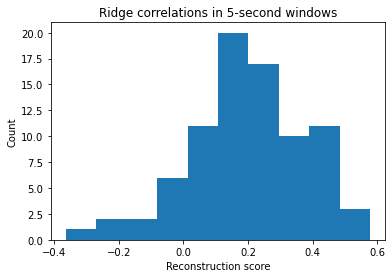

In [32]:
from pipeline.helpers import get_scores

with h5py.File(data_dir, 'r') as f:
    envelope = np.hstack([f[f'stim/part{j}'][:] for j in test_parts])
    
ridge_predictions = np.load("../results/linear_models/P00_predictions.npy")[0]

# get correlation coefficient in each 5-second window:
ridge_scores = get_scores(envelope, ridge_predictions, batch_size=5*125)

plt.hist(ridge_scores, bins=10)

plt.ylabel("Count")
plt.xlabel("Reconstruction score")
plt.title("Ridge correlations in 5-second windows")

# 2. Train the __CNN__ using data from the first participant

- hint: you will need to change the FCNN argument to CNN in the `train_dnn` function
- hint: you will need to load the best parameters into the CNN object instead of the FCNN object
- hint: you will need to use the cnn-specific hyperparameters, instead of the CNN hyperparameters
- hint: __you don't need to tune the learning rate for this part__

Please calculate the test score for the CNN

In [ ]:
validation_accuracy, state_dict = train_dnn(data_dir,
                                            participants = participant,
                                            checkpoint_path=None,
                                            model_handle=CNN,#FCNN
                                            train_parts = train_parts,
                                            val_parts = val_parts,
                                            epochs=5,
                                            early_stopping_patience=3,
                                            **cnn_train_params,#**fcnn_train_params
                                            **cnn_hyperparameters#**fcnn_hyperparameters)

# 3. Tune the learning for your assigned DNN and participant. Save your predictions on the test dataset, and email them to me at mdt20@ic.ac.uk

- We have tuned the learning rate for the FCNN, for participant 0. You may be assigned to repeat this procedure for the CNN, for participant 6.
- In this case, you would save your predictions as a single array in the format P06_CNN_predictions.npy